## Solve Loads

In [1]:
# %%file SolveLoads.py
import sys
sys.path.append('../')

import numpy as np
from Equilibrium import *
from constants import *

def SolveACLoads(cg, acf, acb):
    Weight = PointLoad([0, - mTO * 9.81, 0], [cg, 0, 0])
    LFront = PointLoad([0, 1, 0], [acf, 0, 0])
    LBack = PointLoad([0, 1, 0], [acb, 0, 0])
    motion = EquilibriumEquation(kloads = [Weight], ukloads=[LFront, LBack])
    motion.SetupEquation()
    return list(motion.SolveEquation())

def SolveWingLoads(MAC, b, Lwing, Dwing, mWing, TpE, nE):
    pos = np.linspace(0, b / 2)
    WingWeight = RunningLoad([[0]*len(pos), [- mWing * 9.81 / b]*len(pos)], pos, axis=2)
    Lift = RunningLoad([[0]*len(pos), [Lwing / b] * len(pos)], pos, axis=2)
    Drag = RunningLoad([[Dwing / b] * len(pos), [0]*len(pos)], pos, axis=2)
    Thrust = [PointLoad([-TpE, 0, 0], [0, 0, i]) for i in np.linspace(0, b/2, round(N_cruise/4))]
    MomentAC = Moment(value=[0, 0, 30])

    Fixedx = PointLoad([1, 0, 0], [0.5 * MAC, 0, 0])
    Fixedy = PointLoad([0, 1, 0], [0.5 * MAC, 0, 0])
    Fixedz = PointLoad([0, 0, 1], [0.5 * MAC, 0, 0])

    FixedMomentx, FixedMomenty, FixedMomentz = Moment([1, 0, 0]), Moment([0, 1, 0]), Moment([0, 0, 1])
    wingequation = EquilibriumEquation(kloads=[WingWeight, Lift, Drag, MomentAC] + Thrust,
                                       ukloads=[Fixedx, Fixedy, Fixedz, FixedMomentx, FixedMomenty, FixedMomentz])
    wingequation.SetupEquation()
    return wingequation

In [2]:
print(ACLoads := SolveACLoads(1.95, 0.5, 3.5))
wingequation = SolveWingLoads(0.2, 11.2, ACLoads[0], 800, mTO / 8, 100, 3)
print(WingLoads := list(wingequation.SolveEquation()))

NameError: name 'mTO' is not defined

In [3]:
from IPython.display import Math, display
show = lambda func: display(Math(func.__str__()))

In [4]:
# uk: [ Fixedx, Fixedy, Fixedz, FixedMomentx, FixedMomenty, FixedMomentz ]
# C1: [ -700.      -7419.38475     0.      20774.2773    -1960.       0. ]
# C2: [ -600.      -7103.66625     0.      19890.2655    -1680.       0. ]
# C3: [ -800.    -14883.87214286   0.     41674.842      -2240.       0. ]

## Structures

In [2]:
# %%file Geometry.py
import numpy as np
from numpy import pi
from MathFunctions import StepFunction
import pandas as pd

class StructuralError(Exception):
    def __init__(self, msg):
        super().__init__(msg)

class Stringer:
    def __init__(self, area = 0.001, point = (0, 0), **kwargs):
        self.a, (self.x, self.y) = area, point
        
    __repr__ = __str__ = lambda self: f"Stringer(Area={str(self.a)}, Position={str(self.x), str(self.y)})"
    
    Ixx = lambda self: self.a * self.y**2
    Iyy = lambda self: self.a * self.x**2

class ZStringer(Stringer):
    def __init__(self, point = (0, 0), bflange = 0.05, tflange = 0.05, vflange = 0.05, tstr = 0.001):
        super().__init__((tflange + bflange1 + bflange2 + 2*vflange)*tstr, point)
        self.bflange, self.tflange, self.vflange, self.t = bflange, tflange, vflange, tstr

        self.a = (self.bflange + self.tflange + self.vflange) * self.t
    ccarea = lambda self: self.a
    __repr__ = __str__ = lambda self: "Z-Stringer(" + ', '.join(f"{k}={self.__dict__[k]}" for k in self.__dict__) + ")"
    
    def cripplingStress(self, E, v, sigma_y):
        alpha, n = 0.8, 0.6
        sdict = {}
        sdict['ccstress1'] = 0.8 * (0.425/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / self.bflange)**2) ** (1 - n) * sigma_y
        sdict['ccstress2'] = 0.8 * (0.425/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / self.tflange)**2) ** (1 - n) * sigma_y
        sdict['ccstress3'] = 0.8 * (4/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / self.vflange)**2) ** (1 - n) * sigma_y
        for (key, value) in sdict.items():
            if value > sigma_y:
                sdict[key] = sigma_y
        return (sdict['ccstress1'] * self.t * self.bflange 
                + sdict['ccstress2'] * self.t * self.tflange
                + sdict['ccstress3'] * self.t * self.vflange) / self.a
    
class HatStringer(Stringer):
    def __init__(self, point = (0, 0), bflange1 = 0.05, bflange2 =0.05, tflange = 0.05, vflange = 0.05, tstr = 0.001):
        super().__init__((tflange + bflange1 + bflange2 + 2*vflange)*tstr, point)
        self.bflange1, self.bflange2, self.tflange, self.vflange, self.t = bflange1, bflange2, tflange, vflange, tstr
        self.a = (self.bflange1 + self.bflange2 + self.tflange + 2*self.vflange) * self.t
        
    ccarea = lambda self: self.a
    __repr__ = __str__ = lambda self: "HAT-Stringer(" + ', '.join(f"{k}={self.__dict__[k]}" for k in self.__dict__) + ")"
    
    
    def cripplingStress(self, E, v, sigma_y):
        alpha, n = 0.8, 0.6
        sdict = {}
        sdict['ccstress1'] = 0.8 * (0.425/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / (self.bflange1))**2) ** (1 - n) * sigma_y
        sdict['ccstress5'] = 0.8 * (0.425/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / (self.bflange2))**2) ** (1 - n) * sigma_y
        sdict['ccstress24'] = 0.8 * (4/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / (self.vflange))**2) ** (1 - n) * sigma_y
        sdict['ccstress3'] = 0.8 * (4/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / (self.tflange))**2) ** (1 - n) * sigma_y
        for (key, value) in sdict.items():
            if value > sigma_y:
                sdict[key] = sigma_y
        return (sdict['ccstress1'] * self.t * self.bflange1
                + sdict['ccstress5'] * self.t * self.bflange2
                + 2 * sdict['ccstress24'] * self.t * self.vflange + sdict['ccstress3'] * self.t * self.tflange) / self.a

class JStringer(Stringer):
    def __init__(self, point = (0, 0), bflange1 = 0.05, bflange2 =0.05, tflange = 0.05, vflange = 0.05, tstr = 0.001):
        super().__init__((tflange + bflange1 + bflange2 + 2*vflange)*tstr, point)
        self.bflange1, self.bflange2, self.tflange, self.vflange, self.t = bflange1, bflange2, tflange, vflange, tstr
        
        self.a = (self.bflange1 + self.bflange2 + self.tflange + self.vflange) * self.t
        
    ccarea = lambda self: self.a
    __repr__ = __str__ = lambda self: "J-Stringer(" + ', '.join(f"{k}={self.__dict__[k]}" for k in self.__dict__) + ")"
    
    def cripplingStress(self, E, v, sigma_y):
        alpha, n = 0.8, 0.6
        self.sdict = {}
        self.sdict['ccstress1'] = 0.8 * (0.425/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / (self.bflange1))**2) ** (1 - n) * sigma_y
        self.sdict['ccstress2'] = 0.8 * (0.425/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / (self.bflange2))**2) ** (1 - n) * sigma_y
        self.sdict['ccstress3'] = 0.8 * (4/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / (self.vflange))**2) ** (1 - n) * sigma_y
        self.sdict['ccstress4'] = 0.8 * (0.425/sigma_y * (np.pi**2 * E / (12 * (1 - v**2))) * (self.t / (self.tflange))**2) ** (1 - n) * sigma_y
        for (key, value) in self.sdict.items():
            if value > sigma_y:
                self.sdict[key] = sigma_y
        return (self.sdict['ccstress1'] * self.t * self.bflange1
                + self.sdict['ccstress2'] * self.t * self.bflange2
                + self.sdict['ccstress3'] * self.t * self.vflange + self.sdict['ccstress4'] * self.t * self.tflange) / self.a
    
class WingBox:
    def __init__(self, thicknessOfSkin, thicknessOfSpar, base, height, stringers = []):
        self.b, self.h, self.tsk, self.tsp = base, height, thicknessOfSkin, thicknessOfSpar
        self.str = stringers
        tstrs, bstrs = sum(1 for stringer in stringers if stringer.y > 0), sum(1 for stringer in stringers if stringer.y < 0)
        self.tspitch, self.bspitch = self.b/(tstrs + 1), self.b/(bstrs + 1)

    
    __str__ = __repr__ = lambda self: \
    f"Wingbox(Height={str(self.h)}, Base={str(self.b)}, Tsk = {str(self.tsk)}, Tsp = {str(self.tsp)}, Stringers = {len(self.str)})"
    
    Area = lambda self: self.b * self.h - (self.b - 2 * self.tsp) * (self.h - 2 * self.tsk) + sum(s.a for s in self.str)

    Ixx = lambda self: (self.tsp * self.h ** 3 + self.b * self.tsk ** 3) / 6 + (self.tsk * self.b * self.h ** 2) / 2 + sum(s.Ixx() for s in self.str)
    
    Iyy = lambda self: (self.tsk ** 3 * self.h + self.b ** 3 * self.tsp) / 6 + (self.tsp * self.h * self.b ** 2) / 2 + sum(s.Iyy() for s in self.str)
    
    Vc = Ixy = lambda self: 0
    
    def StrPlacement(self, nstr_top:int , nstr_bottom:int, stringerGeometry = {}, stringerType = 'Point'):
        strtype = {'Z':ZStringer, 'Hat':HatStringer, 'J':JStringer, 'Point': Stringer}[stringerType]
        topstringers = [strtype(point = (i*self.b/(nstr_top + 1) - self.b/2, self.h/2), **stringerGeometry) for i in range(1, nstr_top+1)]
        bottomstringers = [strtype(point = (i*self.b/(nstr_bottom + 1) - self.b/2, -self.h/2), **stringerGeometry) for i in range(1, nstr_bottom+1)]
        self.tspitch, self.bspitch = self.b/(nstr_top + 1), self.b/(nstr_bottom + 1)
        self.str = self.str.copy() + topstringers + bottomstringers
        
    def Vshear(self, Vy, x, y):
        Ixx = self.Ixx()
        inrge = lambda l1, u1, l2, u2: l1 <= x <= u1 and l2 <= y <= u2
        vit = - Vy * self.tsp / Ixx if (-self.b/2 <= x <= -self.b/2 + self.tsp) or (self.b/2 - self.tsp <= x <= self.b/2) else - Vy * self.tsk / Ixx
        if inrge(0, self.b/2 - 1.5*self.tsp, -self.h/2, -self.h/2 + self.tsk):
            return vit * (-self.h * x / 2)
        elif inrge(self.b/2-1.5*self.tsp, self.b/2, -self.h/2, self.h/2):
            s = self.h/2 + y
            return vit * (0.5 * s * s - self.h * s / 2) + self.Vshear(Vy, self.b/2 - 1.5*self.tsp, -self.h/2)
        elif inrge(-self.b/2 + 1.5*self.tsp, self.b/2 - 1.5*self.tsp, self.h/2-self.tsk, self.h/2):
            s = self.b/2 - x
            return vit * (self.h*s/2) + self.Vshear(Vy, self.b/2, self.h/2)
        elif inrge(-self.b/2, -self.b/2+1.5*self.tsp, -self.h/2, self.h/2):
            s = self.h/2 - y
            return vit * (-0.5 * s * s + self.h * s / 2) + self.Vshear(Vy, -self.b/2 + 1.5*self.tsp, self.h/2)
        elif inrge(-self.b/2 + 1.5*self.tsp, 0, -self.h/2, -self.h/2+self.tsk):
            return vit * (-self.h * (x + self.b/2) / 2) + self.Vshear(Vy, -self.b/2, -self.h/2)
        else:
            raise ValueError(f"Invalid Coordinates Supplied: {(x, y) = }")

    def Hshear(self, Vx, x, y):
        Iyy = self.Iyy()
        inrge = lambda l1, u1, l2, u2: l1 <= x <= u1 and l2 <= y <= u2
        vit = - Vx * self.tsp / Iyy if (-self.b/2 <= x <= -self.b/2 + self.tsp) or (self.b/2 - self.tsp <= x <= self.b/2) else - Vx * self.tsk / Iyy
        if inrge(-self.b/2, -self.b/2+self.tsp, -self.h/2, 0):
            return vit * (self.b * y / 2)
        elif inrge(-self.b/2, self.b/2, -self.h/2, -self.h/2+self.tsk):
            s = x + self.b/2
            return vit * (0.5 * s * s - self.b * s / 2) + self.Hshear(Vx, -self.b/2, -self.h/2)
        elif inrge(self.b/2 -self.tsp, self.b, -self.h/2, self.h/2):
            return vit * (self.b * (y + self.h/2) / 2) + self.Hshear(Vx, self.b/2, -self.h/2)
        elif inrge(-self.b/2, self.b/2, self.h/2-self.tsk, self.h/2):
            s = -x + self.b/2
            return vit * (-0.5 * s * s + self.b * s / 2) + self.Hshear(Vx, self.b/2, self.h/2)
        elif inrge(-self.b/2, -self.b/2+self.tsp, 0, self.h/2):
            return vit * (-self.b * (self.h/2-y) / 2) + self.Hshear(Vx, -self.b/2, self.h/2)
        else:
            raise ValueError(f"Invalid Coordinates Supplied: {(x, y) = }")
    
    q = lambda self, x, y, Vx=0, Vy=0, T=0: self.Vshear(Vy, x, y) + self.Hshear(Vx, x, y) + T / (2 * self.Area())
    tau = lambda self, x, y, Vx=0, Vy=0, T=0: self.q(x, y, Vx, Vy, T) / (self.tsp if \
        (-self.b/2 <= x <= -self.b/2 + self.tsp) or (self.b/2 - self.tsp <= x <= self.b/2) else self.tsk)
    
    o = lambda self, x, y, Mx=0, My=0: My * x / self.Iyy() + Mx * y / self.Ixx()
    
    def Bstress(self, EofStringers, vOfStringers, yieldOfStringers, EofSkin, vOfSkin, top_panel = True):
        # stringer properties - in case different material is used
        Estr, vstr, ystr = EofStringers, vOfStringers, yieldOfStringers
        ccstr = self.str[0].cripplingStress(Estr, vstr, ystr)
        ccarea = self.str[0].ccarea()
        # skin properties
        Esk, vsk = EofSkin, vOfSkin
        # pitch depends on which panel is taken, top or bottom
        pitch = self.tspitch if top_panel else self.bspitch
        sigma_crskin = 4 * (np.pi ** 2 * Esk/(12 * (1 - vsk**2)))*(self.tsk / (pitch))**2
        C = 6.98 if pitch/self.tsk > 75 else 4
        we = 0 #self.tsk * np.sqrt(np.pi ** 2 * C * Esk/(ccstr*12*(1-vsk**2)))
        new_pitch = pitch - we
        new_sigma_crskin = 4 * (np.pi ** 2 * Esk/(12 * (1 - vsk**2)))*(self.tsk / (new_pitch))**2
        if new_pitch < 0:
            raise StructuralError("Invalid pitch length: " + str(new_pitch))
        return (new_sigma_crskin * new_pitch * self.tsk + ccstr * (ccarea + we * self.tsk))/ (new_pitch * self.tsk + (ccarea + we * self.tsk))

class WingStructure:
    def __init__(self, span, taper, rootchord, wingbox):
        self.span, self.taper, self.rc = span, taper, rootchord
        self.tc = self.rc * self.taper
        self.box = wingbox
    
    chord = lambda self, z: self.rc * (self.taper - 1) * z / (self.span/2) + self.rc if (0 <= z <= self.span/2) else None
    __call__ = lambda self, z: WingBox(self.box.tsk, self.box.tsp, self.box.b*self.chord(z), self.box.h*self.chord(z), self.box.str)
    __repr__ = __str__ = lambda self: "WingStructure(" + ', '.join(f"{k}={self.__dict__[k]}" for k in self.__dict__) + ")"
    area = lambda self: 0.5 * self.rc * (1 + self.taper) * self.span

stress, pitch, nstr = (24.571317224631212, 0.6, 0)
stress, pitch, nstr = (43.882578059792706, 0.3, 1)
stress, pitch, nstr = (60.037805061272344, 0.19999999999999998, 2)
stress, pitch, nstr = (74.15089252331077, 0.15, 3)
stress, pitch, nstr = (86.86672661625789, 0.12, 4)
stress, pitch, nstr = (98.58452258842549, 0.09999999999999999, 5)
stress, pitch, nstr = (109.56463821045166, 0.08571428571428572, 6)
stress, pitch, nstr = (119.98411676637038, 0.075, 7)


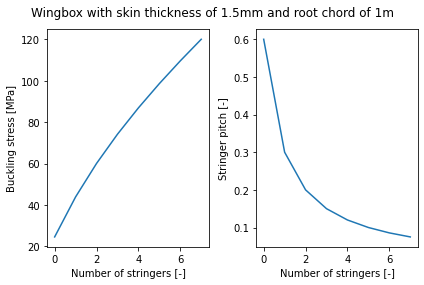

In [2]:
import matplotlib.pyplot as plt
rootchord = 1
ntofit=10
thicknessOfStringer=1e-3
wingbox_t = 0.0015
# geom = dict(bflange1 = 0.02, bflange2 =0.02, tflange = 0.02, vflange = 0.035, tstr = 0.001)
geom = dict(bflange1 = rootchord / (ntofit * 3), 
                            bflange2 = rootchord / (ntofit * 3),
                            tflange = rootchord / (ntofit * 3),
                            vflange = 1.5 * rootchord / (ntofit * 3),
                            tstr = thicknessOfStringer)

# geom2 = dict(bflange = 0.04, tflange = 0.02, vflange = 0.07, tstr = 0.001)
# geom3 = dict(bflange1 = 0.02, bflange2 =0.02, tflange = 0.02, vflange = 0.07, tstr = 0.001)
x = np.arange(0,8)
y = []
ptch = []
for nstr in range(0,8):
    wingbox = WingBox(wingbox_t, 0.01, rootchord*0.6, 0.085) # WingBox(1e-3, 3e-3, 0.3, 0.06)
    wingbox.StrPlacement(nstr, 1, geom, 'Hat')
    # wingbox2 = WingBox(1e-3, 10e-3, 1, 0.2)
    # wingbox2.StrPlacement(8, 2, 0.001, geom2, 'Z')
    # wingbox3 = WingBox(1e-3, 10e-3, 1, 0.2)
    # wingbox3.StrPlacement(8, 2, 0.001, geom3, 'J')
    # wingbox.str[0].cripplingStress(72e9, 0.33, 503e6)*1e-6
    # print(wingbox.Bstress(72e9, 0.33, 275e6, 72e9, 0.33)*1e-6, wingbox.str[0].ccarea(),
    #      (wingbox.Bstress(72e9, 0.33, 275e6, 72e9, 0.33)*1e-6) / (wingbox.b * wingbox.tsk + wingbox.str[0].ccarea()*8) * 1e-6)
    # print(wingbox2.Bstress(72e9, 0.33, 275e6, 72e9, 0.33)*1e-6, wingbox2.str[0].ccarea(), 
    #      (wingbox2.Bstress(72e9, 0.33, 275e6, 72e9, 0.33)*1e-6) / (wingbox2.b * wingbox2.tsk + wingbox2.str[0].ccarea()*8) * 1e-6)
    # print(wingbox3.Bstress(72e9, 0.33, 275e6, 72e9, 0.33)*1e-6, wingbox3.str[0].ccarea(), 
    #      (wingbox3.Bstress(72e9, 0.33, 275e6, 72e9, 0.33)*1e-6) / (wingbox3.b * wingbox3.tsk + wingbox3.str[0].ccarea()*8) * 1e-6)
    stress = wingbox.Bstress(72e9, 0.33, 241e6, 72e9, 0.33)*1e-6
    pitch = wingbox.tspitch
    y.append(stress)
    ptch.append(pitch)
    print(f"{stress, pitch, nstr = }")
figure, axs = plt.subplots(1, 2)
axs[0].plot(x, np.array(y))
axs[1].plot(x, np.array(ptch))
axs[0].set_ylabel('Buckling stress [MPa]')
axs[0].set_xlabel('Number of stringers [-]')
axs[1].set_ylabel('Stringer pitch [-]')
axs[1].set_xlabel('Number of stringers [-]')
figure.tight_layout()
figure.suptitle(f'Wingbox with skin thickness of {wingbox_t*1e3}mm and root chord of {rootchord}m')
plt.subplots_adjust(top = 0.9)
plt.show()
figure.savefig('Buckling_verif.jpg')

In [14]:
geom_verif = dict(bflange1 = 0.02, bflange2 =0.02, tflange = 0.02, vflange = 0.035, tstr = 0.002)
wingbox_verif = WingBox(0.0015, 0.01, 0.8, 0.153)
wingbox_verif.StrPlacement(3,1,geom_verif, 'Hat')
wingbox_verif.Bstress(72e9, 0.334, 503e6, 72e9, 0.334)*1e-6

214.9353564413934

In [3]:
# bflange1 = 0.05, bflange2 =0.05, tflange = 0.05, vflange = 0.05, tstr = 0.001
# hatstr = HatStringer(bflange1 = 0.02, bflange2 =0.02, tflange = 0.02, vflange = 0.035, tstr = 0.002)
# E, v, sigma_y = 72e9, 0.334, 503e6
# hatstr.cripplingStress(E, v, sigma_y)*1e-6
jstr = JStringer(bflange1 = 0.02, bflange2 =0.02, tflange = 0.02, vflange = 0.03, tstr = 0.0015)
jstr.cripplingStress(72e9, 0.3, 450e6)*1e-6

296.004438501156

In [4]:
wing = WingStructure(10, 0.4, 0.5, wingbox)
for i in range(6):
    print(wing(i), wing.chord(i))

Wingbox(Height=0.0425, Base=0.3, Tsk = 0.0015, Tsp = 0.01, Stringers = 8) 0.5
Wingbox(Height=0.0374, Base=0.264, Tsk = 0.0015, Tsp = 0.01, Stringers = 8) 0.44
Wingbox(Height=0.0323, Base=0.22799999999999998, Tsk = 0.0015, Tsp = 0.01, Stringers = 8) 0.38
Wingbox(Height=0.027200000000000002, Base=0.192, Tsk = 0.0015, Tsp = 0.01, Stringers = 8) 0.32
Wingbox(Height=0.0221, Base=0.156, Tsk = 0.0015, Tsp = 0.01, Stringers = 8) 0.26
Wingbox(Height=0.017, Base=0.12, Tsk = 0.0015, Tsp = 0.01, Stringers = 8) 0.2


In [5]:
wing = WingStructure(wingequation)
wing.compute_loading()
show(wing.My)
show(wing.compute_deflections(60e9, 1.005e-4, 1.005e-2)[0])

NameError: name 'wingequation' is not defined

In [ ]:

box = WingBox()

## Data Processing

In [ ]:
import numpy as np

materials = pd.read_html('https://mechanicalc.com/reference/material-properties-tables')
matdfs = {"Carbon Steel": materials[1], "Alloy Steel": materials[2], "Stainless Steel": materials[3], "Cast Iron": materials[4],
         "Aluminum Alloys": materials[5], "Nickel Alloys": materials[6], "Copper Alloys": materials[7], "Titanium Alloys": materials[8]}

for m in matdfs:
    matdfs[m]['Class'] = m
    matdfs[m] = matdfs[m].iloc[:-1]
df = pd.concat(matdfs.values())
description = {}
num_cols = ['YieldStrength [ksi]', 'UltimateStrength [ksi]', 'Elongation%', 'Density[lb/in3]', "Poisson'sRatio"]
for num in num_cols:
    tit = ''.join([letter for letter in num if letter not in ['[', ']', '/', '3', ' ', '%', "'", "'"] and letter.upper() == letter])
    description[tit] = num
    df[tit] = pd.to_numeric(df[num], errors='coerce')

df.drop(columns=num_cols, inplace=True)

df[['YS', 'US']] *= 6.89476e6 # psi --> Pa
df['ElasticModulus [psi]'] = df['ElasticModulus [psi]'].apply(lambda x: np.mean(np.float64(x.replace('e6', '').split(' - '))) * 6.89476e9)
df['D'] *= 27679.9 # lb/in3 --> kg/m3
df.E /= 100 # %
df.rename(columns={'E': 'elong', 'ElasticModulus [psi]': 'E', 'D': 'rho', 'US': 'oult', 'YS': 'oyield', 'PR': 'v'}, inplace=True)
df = df.replace('---', np.nan)
df.head()

In [ ]:
paris = pd.read_json('materials.json')

def transform(x):
    clm = [col for col in paris.columns if col in x['Class']]
    if len(clm):
        x['ParisA'] = paris[clm[0]]['A']
        x['Parism'] = paris[clm[0]]['m']
    return x

df = df.apply(transform, axis=1)
df.head()

In [ ]:
df.to_csv('materials.csv', index=False)

## Materials

In [7]:
%%file Material.py
import pandas as pd
from scipy.integrate import quad
from numpy import cos, sin, pi

class Material:
    def __init__(self, E, density, o_yield, o_ult, Paris=(None, None), name=None, poisson=0.33, SNfp = 1697, SNb = -0.176, **others):
        self.E, self.rho, self.oy, self.oult, self.v = E, density, o_yield, o_ult, poisson
        self.C, self.m = Paris
        self.props = others
        self.name = name
        self.SNfp, self.SNb = SNfp, SNb
        
    __repr__ = __str__ = lambda self: (self.name if self.name else "Material")+f"(E={self.E}, ρ={self.rho}, σy={self.oy}, σult={self.oult})"
    
    def buckling(self, shorterSideOfSkin, skinThickness):
        C = 5.41 # SSCS Support
        b = shorterSideOfSkin
        t = skinThickness
        return C * pi * pi * self.E * (t / b) ** 2 / (12 * (1 - self.v ** 2))
    
    @staticmethod
    def load(file='materials.csv', material='Al 6061', Condition='T6'):
        df = pd.read_csv(file)
        check = df[df['Material'] == material]
        if len(check) == 0:
            raise KeyError(f'No {material = } could be found')
        elif len(check) == 1:
            mat = check.iloc[0]
        else:
            mat = check[check['Condition'] == Condition].iloc[0]
        return Material(mat.E, mat.rho, mat.oyield, mat.oult, (mat.ParisA, mat.Parism), mat.Material, mat.v)
    
    @staticmethod
    def beta(aow, center=False): 
        return (1/cos(pi * aow)) ** 0.5 if center else 1.1215 # pg 131

    @staticmethod
    def StressConcentration(beta, a, o):
        return beta * o * (pi * a) ** 0.5
    
    def ParisFatigueN(self, Smax, Smin, w, ai, af):
        R, dS = Smin / Smax, Smax - Smin
        U = 0.5 + 0.4 * R
        def integrand(a):
            beta = self.beta(a/w)
            return 1 / (U * self.StressConcentration(beta, a, dS))**self.m
        N = (1/self.C) * quad(integrand, ai, af)[0]
        return N
    
    ParisFatigueda = lambda self, a, w, Smax, Smin, n: \
        (0.5 + 0.4 * abs(Smin / Smax)) * n * self.C * (self.beta(a/w) * abs(Smax - Smin) * (pi * a) ** 0.5) ** self.m 
    
    BasquinLaw = lambda self, S: (S / self.SNfp) ** (1 / self.SNb)

Overwriting Material.py


In [27]:
al = Material.load(file='../data/materials.csv', material='Al 7075')
al.BasquinLaw(100 / 2)

497996570.7386181

In [46]:
steel = Material.load(file='../data/materials.csv', material='AISI 1045', Condition='Annealed')
steel.C = 1.294e-12
steel.m = 3.4
steel.ParisFatigueN(100, 0, 1, 5e-3, 100e-3) / steel.ParisFatigueN(100, 0, 1, 5e-3, 50e-3)

1.0958225391725043

In [ ]:
materials = pd.read_csv('../data/materials.csv')
materials['Cost'] = materials.rho / materials.E ** (1/3)
costs = materials.groupby('Class').agg({'Cost': 'max'}).reset_index()
costsal = materials[materials['Class'] == 'Aluminum Alloys'].groupby(['Material', 'Condition']).agg({'Cost': 'max'}).reset_index()
materials.info()

In [ ]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.barplot(x='Class', y='Cost', data=costs)
plt.ylabel(r'Cost $\left(kg \times m^{-3} \times MPa^{-1/3} \right)$')
plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.barplot(x='Material', y='Cost', data=costsal, palette='rainbow')
plt.ylabel(r'Cost $\left(kg \times m^{-3} \times MPa^{-1/3} \right)$')
plt.savefig('materials.jpg')

In [ ]:
import plotly.express as px
fig = px.bar(costs, x='Class', y='Cost', color='Class', height=400)
fig.show(renderer='iframe')

## Structural Analysis

In [ ]:
# %%file StructuralAnalysis.py
import sys
import json
import numpy as np
sys.path.append('../')
sys.path.append('../Sizing')
from constants import *
from maneuvre import plotgustenv, plotmaneuvrenv

from cg_est import Wing, Fuselage, LandingGear, Propulsion, Weight
from SolveLoads import SolveACLoads, SolveWingLoads, SolveVLoads, SolveVWingLoads
from Analysis import WingBox, WingStructure
from Material import Material

config = inputconfig
WoS = 1422
Pmax = 8.77182
mProp = 400 / N_cruise
thickness = 3e-3
w_fus= 1.3; h_fus=1.6; l_fus=4

nmax = max(plotgustenv(0.75 * V_cruise, V_cruise, CLalpha_back, WoS), plotmaneuvrenv(WoS, V_cruise, CLmax_back))

w = Weight(95, Wing(mTO, S_front, S_back, 1.5*nmax, AR, [0.4, 3.6], config),
           Fuselage(mTO, Pmax, l_fus, 5, l_fus/2, config),
          LandingGear(mTO, l_fus/2),
          Propulsion(N_cruise, [mProp]*N_cruise, pos_prop=[3.6]*int(N_cruise/2) + [0.4]*int(N_cruise/2)),
          cargo_m, cargo_p, Bat_mass, l_fus/2, [0.8, 1.3, 1.3, 2.5, 2.5])

wf = w.print_weight_fractions()
b = (S_front * AR) ** 0.5

LpWing = SolveACLoads(w.mtom_cg, *w.wing.pos)

wingEquation = SolveWingLoads(MAC1, b, 1.5*nmax*LpWing[0]/2, mTO*9.81 / LD_ratio, w.wing.get_weight()[0]/2, 
                              mTO*9.81 / (LD_ratio*N_cruise), N_cruise)

wingEquation.SetupEquation()
Fx, Fy, Fz, Mx, My, Mz = wingEquation.SolveEquation()
wingS = WingStructure(wingEquation)
N, Vx, Vy, Mx, My, Mz = wingS.compute_loading()

box = WingBox(thickness, 0.8 * c_r, 0.8 * 0.17 * c_r)
tau = lambda x, y, z: box.tau(x, y, Vx(z), Vy(z), Mz(z))
ozz = lambda x, y, z: box.o(x, y, Mx(z), My(z)) + N(z) / box.Area()

stresses = np.array([[ozz(x, y, 0) for x in np.linspace(-box.b/2, box.b/2)] for y in np.linspace(-box.h/2, box.h/2)], dtype='float64')
am = stresses.argmax()

omax, taumax = stresses.flatten()[am]*1e-6, tau(box.b/2, -box.h/2, 0)*1e-6

Ymax = (omax ** 2 + 3 * taumax ** 2) ** 0.5

aluminum = Material.load(file='materials.csv', material='Al 6061', Condition='T6')
N = aluminum.ParisFatigueN(stresses.flatten()[am], box.b, box.t / 3, box.t/2)
# aluminum.StressConcentration(aluminum.beta(0.01), 50e-3, 100*1e6)

xd, yd = wingS.compute_deflections(aluminum.E, box.Ixx(), box.Iyy())

critBuckling = aluminum.buckling(box.h, box.t)*1e-6
wingS = WingStructure(wingEquation)

ThrustVTOL = SolveVLoads(w.mtom_cg, *w.wing.pos)
wingVTOL = SolveVWingLoads(MAC1, b, mTO*9.81 / LD_ratio, w.wing.get_weight()[0]/2,
                        sum(ThrustVTOL) / (N_hover), N_hover)

Fx, My = wingVTOL.SolveEquation()

box = WingBox(thickness, 0.8 * c_r, 0.8 * 0.17 * c_r) if config != 1 else WingBox(thickness, 0.8 * 0.17 * c_r, 0.8 * c_r)

ozzVTOL = lambda x, y: box.o(x, y, 0, My) + Fz / box.Area()
tauVTOL = lambda x, y: box.tau(x, y, Fx)

stresses = np.array([[ozzVTOL(x, y) for x in np.linspace(-box.b/2, box.b/2)] for y in np.linspace(-box.h/2, box.h/2)], dtype='float64')
am = stresses.argmax()

omaxVTOL, taumaxVTOL = stresses.flatten()[am]*1e-6, tauVTOL(0, -box.h/2)*1e-6

YmaxVTOL = (omaxVTOL ** 2 + 3 * taumaxVTOL ** 2) ** 0.5

output = dict(config = config, WingLoading = WoS, maxPerimeter = Pmax, mPropellers = mProp, weightFractions = wf,
              MaxNormalStress=omax, MaxShearStress=taumax, critBucklingStress=critBuckling, fatigueLife=N, deflectionX = xd(b/2),
             deflectionY = yd(b/2), maxVonMises = Ymax, EOW = w.oem*9.81, MTOW = w.mtom*9.81, cgOEM = w.oem_cg, cgMTOM = w.mtom_cg,
             Passed = bool(omax < critBuckling and N > 365 * 3 * 15 and Ymax < aluminum.oy), w_fus= 1.3, h_fus=1.6, l_fus=4,
             omaxVTOL = omaxVTOL, taumaxVTOL = taumaxVTOL)




with open("output.json", "r") as o:
    dic = json.loads(o.read())

dic[["Tandem", "Box", "Single"][config - 1]] = output
# print(output)

op = json.dumps(dic, indent=3)

with open("output.json", "w") as out:
    out.write(op)


# with open(f"../data/inputs_config_{config}.json", "r") as f:
#     dic = json.loads(f.read())

# dic["Structures"] = output
# op = json.dumps(dic, indent=3)

# with open(f"../data/inputs_config_{config}.json", "w") as f:
#     f.write(op)

In [ ]:
from IPython.display import Math, display
show = lambda func: display(Math(func.__str__()))
show(Vy)
show(Mx.derivative())
